<a href="https://colab.research.google.com/github/Inno732/Defi_IA_1_2023_2024/blob/main/3_Input_classification_Fire_detection_2023_2024_tf_inno3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi
!rm -rf sample_data

Sun Nov  5 16:16:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
import math
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)

from keras.applications.densenet import DenseNet121

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

Tensorflow version: 2.14.0


#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [3]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [ ]:
!rm -rf sample_data
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/QP7FoyttxJgS8Cj/download/small.zip
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/REWbK6K4XRtoeNw/download/FIRE_DATABASE_1.zip
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_2.zip # Base de données 3
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/faKyDy7LCxfz9Xk/download/FIRE_DATABASE_3.zip # Base de données 2
! unzip small.zip -d 'bases'
! unzip FIRE_DATABASE_1.zip -d 'bases'
! unzip FIRE_DATABASE_2.zip -d 'bases'
! unzip FIRE_DATABASE_3.zip -d 'bases'
! rm small.zip
! rm FIRE_DATABASE_1.zip
! rm FIRE_DATABASE_2.zip
! rm FIRE_DATABASE_3.zip

#**4. Téléchargement des données de test "Test Dataset"**

In [ ]:
!rm -rf sample_data
!wget https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
!unzip test.zip -d 'bases'
!rm test.zip

#**5. Création du fichier de labels "classes.txt"**

In [6]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [7]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=20 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}
dataset_name='FIRE_DATABASE_3' #@param ["small","FIRE_DATABASE_1","FIRE_DATABASE_2","FIRE_DATABASE_3"]
train_dataset = os.path.join('bases/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "classes.txt"
classifier = "Xception" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [8]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size= (299, 299),      # Taille des images d'entrée
	batch_size= batch_size,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)                             # Generates a 'tf.data.Dataset' from image files in a directory (train_dataset)
print(train_ds.class_names)

Found 1500 files belonging to 3 classes.
Using 1200 files for training.
['fire', 'no_fire', 'start_fire']


In [10]:
# class_names = train_ds.class_names

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)
print(val_ds.class_names)

Found 1500 files belonging to 3 classes.
Using 300 files for validation.
['fire', 'no_fire', 'start_fire']


# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [12]:
model_xception = Xception(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_xception.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_xception = Model(inputs = model_xception.inputs, outputs=predictions)


83683744/83683744 [==============================] - 0s 0us/step


In [13]:
model_VGG16 = VGG16(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_VGG16.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_VGG16 = Model(inputs = model_VGG16.inputs, outputs=predictions)

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
model_VGG19 = VGG19(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# Freezing Layers
for layer in model_VGG19.layers:
    layer.trainable=False

# create a custom top classifier
x = model_VGG19.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_VGG19 = Model(inputs = model_VGG19.inputs, outputs=predictions)

80134624/80134624 [==============================] - 0s 0us/step


In [15]:
# ResNet50 model
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(299, 299,3))

for layer in resnet50.layers:
    layer.trainable = False

# build the entire model
x = resnet50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
#x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
#x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
#x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
model_rsnt50 = Model(inputs = resnet50.input, outputs = predictions)

94765736/94765736 [==============================] - 1s 0us/step


In [16]:
from keras.applications import DenseNet121

# DenseNet201 model
Dsnt201 = DenseNet201(include_top=False, weights='imagenet', input_shape=(299, 299,3))

for layer in Dsnt201.layers:
    layer.trainable = False

# build the entire model
x = Dsnt201.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1072, activation='relu')(x)

predictions = layers.Dense(num_classes, activation='softmax')(x)
model_dsnt201 = Model(inputs = Dsnt201.input, outputs = predictions)

74836368/74836368 [==============================] - 1s 0us/step


In [17]:
# DenseNet121 model
DsNt121 = DenseNet121(weights= 'imagenet', include_top=False, input_shape=(299, 299,3))

# create a custom top classifier
x = DsNt121.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_DsNt121 = Model(inputs = DsNt121.inputs, outputs=predictions)

29084464/29084464 [==============================] - 0s 0us/step


# **10.1 Analyser/visualiser l'architecture de votre modèle avec la fonction summary()**

# **11. Geler puis dégeler les poids des premières couches**

In [18]:
for layer in model_xception.layers:
        layer.trainable = True

In [19]:
for layer in model_VGG16.layers:
        layer.trainable = True

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [20]:
# recompiler le modèle
model_xception.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [21]:
model_VGG16.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [22]:
model_rsnt50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [23]:
model_DsNt121.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [24]:
model_dsnt201.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [25]:
model_VGG19.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [26]:
# model_xception.summary()

In [27]:
# model_VGG16.summary()

In [28]:
# model_rsnt50.summary()

# **12. Entraîner le modèle**

In [ ]:
history_VGG16 = model_VGG16.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

In [ ]:
history_DsNt121 = model_DsNt121.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

In [ ]:
history_xception=model_xception.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

In [ ]:
history_VGG19 = model_VGG19.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

In [ ]:
history_dsnt201 = model_dsnt201.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

In [ ]:
history_rsnt50 = model_rsnt50.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [35]:
model_VGG16.save("model_VGG16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
model_DsNt121.save("model_DsNt121.h5")

In [37]:
model_xception.save("model_xception.h5")

In [38]:
model_rsnt50.save("model_rsnt50.h5")

#**14. Afficher des courbes d'entrainement/validation**

Text(0, 0.5, 'loss')

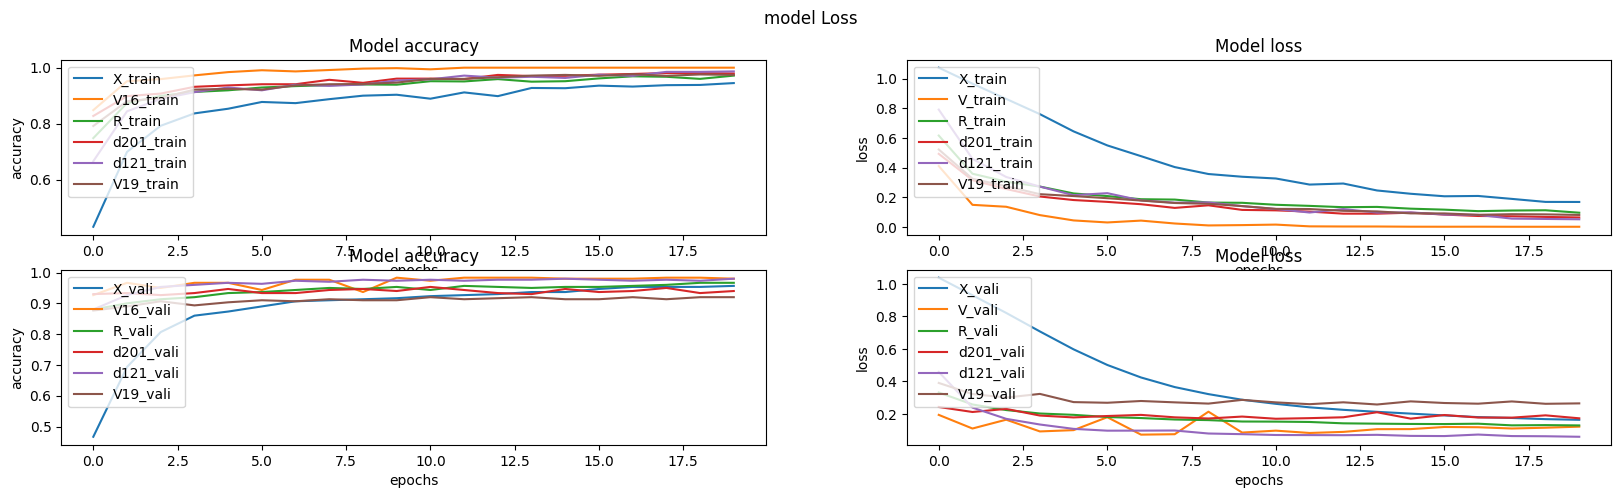

In [51]:
fig, axs= plt.subplots(nrows=2, ncols=2, figsize=(20,5))
fig.suptitle('model Loss')

axs[0, 0].plot(history_xception.history["categorical_accuracy"])
axs[0, 0].plot(history_VGG16.history["categorical_accuracy"])
axs[0, 0].plot(history_rsnt50.history["categorical_accuracy"])
axs[0, 0].plot(history_dsnt201.history["categorical_accuracy"])
axs[0, 0].plot(history_DsNt121.history["categorical_accuracy"])
axs[0, 0].plot(history_VGG19.history["categorical_accuracy"])
axs[0, 0].legend(['X_train', 'V16_train', 'R_train', 'd201_train', 'd121_train', 'V19_train'], loc='upper left')
axs[0, 0].set_title('Model accuracy')
axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("accuracy")

axs[0, 1].plot(history_xception.history["loss"])
axs[0, 1].plot(history_VGG16.history["loss"])
axs[0, 1].plot(history_rsnt50.history["loss"])
axs[0, 1].plot(history_dsnt201.history["loss"])
axs[0, 1].plot(history_DsNt121.history["loss"])
axs[0, 1].plot(history_VGG19.history["loss"])
axs[0, 1].legend(['X_train', 'V_train', 'R_train', 'd201_train', 'd121_train', 'V19_train'], loc='upper left')
axs[0, 1].set_title('Model loss')
axs[0, 1].set_xlabel("epochs")
axs[0, 1].set_ylabel("loss")

axs[1, 0].plot(history_xception.history["val_categorical_accuracy"])
axs[1, 0].plot(history_VGG16.history["val_categorical_accuracy"])
axs[1, 0].plot(history_rsnt50.history["val_categorical_accuracy"])
axs[1, 0].plot(history_dsnt201.history["val_categorical_accuracy"])
axs[1, 0].plot(history_DsNt121.history["val_categorical_accuracy"])
axs[1, 0].plot(history_VGG19.history["val_categorical_accuracy"])
axs[1, 0].legend(['X_vali', 'V16_vali', 'R_vali', 'd201_vali', 'd121_vali', 'V19_vali'], loc='upper left')
axs[1, 0].set_title('Model accuracy')
axs[1, 0].set_xlabel("epochs")
axs[1, 0].set_ylabel("accuracy")

axs[1, 1].plot(history_xception.history["val_loss"])
axs[1, 1].plot(history_VGG16.history["val_loss"])
axs[1, 1].plot(history_rsnt50.history["val_loss"])
axs[1, 1].plot(history_dsnt201.history["val_loss"])
axs[1, 1].plot(history_DsNt121.history["val_loss"])
axs[1, 1].plot(history_VGG19.history["val_loss"])
axs[1, 1].legend(['X_vali', 'V_vali', 'R_vali', 'd201_vali', 'd121_vali', 'V19_vali'], loc='upper left')
axs[1, 1].set_title('Model loss')
axs[1, 1].set_xlabel("epochs")
axs[1, 1].set_ylabel("loss")

# **15. Créer le jeu de données de test**

In [40]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset,
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)

Found 300 files belonging to 3 classes.


# **16. Evaluer le modèle avec ce jeu de données de test avec la fonction evaluate()**

In [41]:
test = model_VGG16.evaluate(test_ds)

38/38 [==============================] - 4s 93ms/step - loss: 0.6054 - categorical_accuracy: 0.9067


In [42]:
test = model_DsNt121.evaluate(test_ds)

38/38 [==============================] - 3s 67ms/step - loss: 0.2956 - categorical_accuracy: 0.8900


In [43]:
test = model_xception.evaluate(test_ds)

38/38 [==============================] - 3s 66ms/step - loss: 0.2792 - categorical_accuracy: 0.9100


In [44]:
test = model_rsnt50.evaluate(test_ds)

38/38 [==============================] - 5s 102ms/step - loss: 0.3873 - categorical_accuracy: 0.8433


In [45]:
test = model_VGG19.evaluate(test_ds)

38/38 [==============================] - 6s 125ms/step - loss: 0.3408 - categorical_accuracy: 0.8933


In [46]:
test = model_dsnt201.evaluate(test_ds)

38/38 [==============================] - 4s 96ms/step - loss: 0.6804 - categorical_accuracy: 0.8300


#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [47]:
files.upload()

Saving fire.jpg to fire.jpg
Saving no_fire.jpg to no_fire.jpg
Saving start_fire.jpg to start_fire.jpg


{'fire.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x15\x12\x12\x12\x15\x15\x15\x15\x17\x17\x15\x17\x15\x15\x17\x15\x15\x15\x17\x17\x18\x17\x17\x17\x17\x15\x17\x15\x18\x1d( \x18\x1a%\x1d\x15\x15!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1a\x10\x10\x1a-&\x1f%--------------------------------------------------\xff\xc0\x00\x11\x08\x00\xdc\x00\xe5\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x01\x04\x05\x00\x06\x07\xff\xc4\x00?\x10\x00\x02\x01\x02\x04\x03\x05\x04\x07\x07\x04\x02\x03\x00\x00\x00\x01\x02\x00\x03\x11\x04\x12!1\x05AQ\x13"aq\x81\x062\x91\xa1Rr\xb1\xb2\xc1\xd1\xf0\x07\x14#BC\x82\xa23b\xe1\xf1\x92\xc2\x154c\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x00\x05\x06\xff\xc4\x002\x11\x00\x02\x02\x01\x03\x02\x04\x05\x04\x02\x02\x03\x01\x00\x00\x00\x00\x01\x02\x11\x03\x

In [54]:
"""%matplotlib inline

axes=[]
fig=plt.figure()
fig = plt.figure(figsize=(18,9))

classes = train_ds.class_names
image_path1 =  "fire.jpg"
image_path2 = "no_fire.jpg"
image_path3 = "start_fire.jpg"
liste_image = [image_path1, image_path2, image_path3]

compteur = 1
for image_path in liste_image:
    # predict Xception.
    img = Image.open(image_path).convert('RGB')
    x = tf.keras.utils.img_to_array(img,data_format='channels_last')
    x = tf.keras.preprocessing.image.smart_resize(x, size=(299,299))
    x = np.expand_dims(x, axis=0)
    pred1 = model_VGG16.predict(x,batch_size=1)[0]

    # predict VGG16 et VGG19.
    img = Image.open(image_path).convert('RGB')
    x = tf.keras.utils.img_to_array(img,data_format='channels_last')
    x = tf.keras.preprocessing.image.smart_resize(x, size=(224,224))
    x = np.expand_dims(x, axis=0)
    pred2 = model_DsNt121.predict(x,batch_size=1)[0]
    pred3 = model_rsnt50.predict(x,batch_size=1)[0]

    liste = [pred1, pred2, pred3]
    for pred in liste:
        for (pos,prob) in enumerate(pred):
            class_name = classes[pos]
            if (pos == np.argmax(pred)) :
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                font = cv2.FONT_HERSHEY_COMPLEX
                textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
                textX = (img.shape[1] - textsize[0]) / 2
                textY = (img.shape[0] + textsize[1]) / 2
                cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
                axes.append(fig.add_subplot(3, 3, compteur))
                plt.imshow(img)
                compteur += 1
            #print("Top %d ====================" % (i + 1))
            print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
        print("----------------------")

plt.show()"""

'%matplotlib inline\n\naxes=[]\nfig=plt.figure()\nfig = plt.figure(figsize=(18,9))\n\nclasses = train_ds.class_names\nimage_path1 =  "fire.jpg"\nimage_path2 = "no_fire.jpg"\nimage_path3 = "start_fire.jpg"\nliste_image = [image_path1, image_path2, image_path3]\n\ncompteur = 1\nfor image_path in liste_image:\n    # predict Xception.\n    img = Image.open(image_path).convert(\'RGB\')\n    x = tf.keras.utils.img_to_array(img,data_format=\'channels_last\')\n    x = tf.keras.preprocessing.image.smart_resize(x, size=(299,299))\n    x = np.expand_dims(x, axis=0)\n    pred1 = model_VGG16.predict(x,batch_size=1)[0]\n\n    # predict VGG16 et VGG19.\n    img = Image.open(image_path).convert(\'RGB\')\n    x = tf.keras.utils.img_to_array(img,data_format=\'channels_last\')\n    x = tf.keras.preprocessing.image.smart_resize(x, size=(224,224))\n    x = np.expand_dims(x, axis=0)\n    pred2 = model_DsNt121.predict(x,batch_size=1)[0]\n    pred3 = model_rsnt50.predict(x,batch_size=1)[0]\n\n    liste = [pre

1/1 [==============================] - 1s 1s/step
Class Name : fire --- Class Probability: 0.74%
Class Name : no_fire --- Class Probability: 97.27%
Class Name : start_fire --- Class Probability: 2.00%


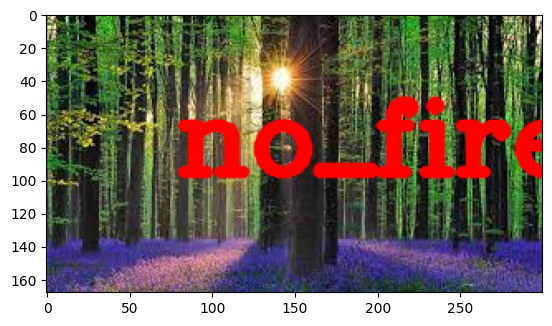

In [52]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "no_fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model_xception.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

1/1 [==============================] - 0s 18ms/step
Class Name : fire --- Class Probability: 0.00%
Class Name : no_fire --- Class Probability: 100.00%
Class Name : start_fire --- Class Probability: 0.00%


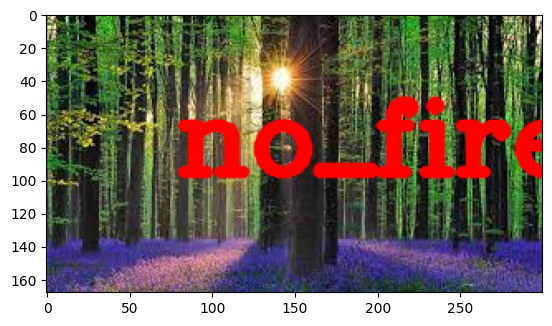

In [53]:
classes = train_ds.class_names
image_path =  "no_fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model_VGG16.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()